# Exercises

In [12]:
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr, poisson
import sys
import os
sys.path.append(os.path.abspath("code"))

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

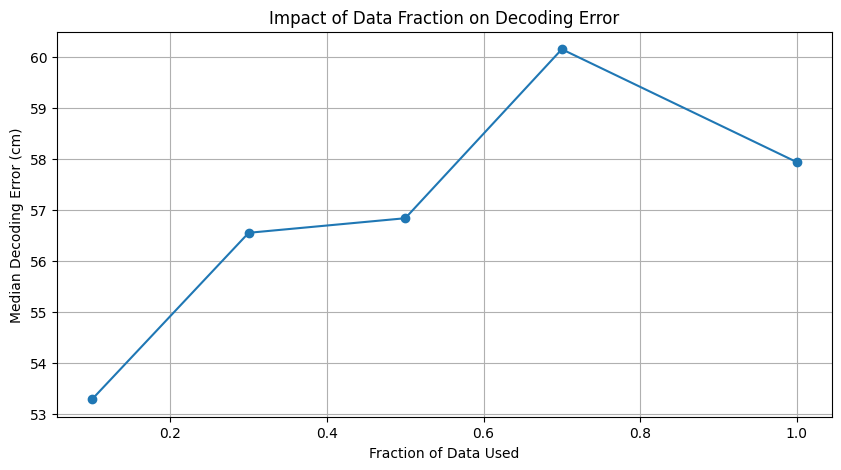

[53.28531855955677,
 56.54761904761905,
 56.83333333333334,
 60.146031746031746,
 57.93363636363637]

In [9]:
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x, t, spikes = data['x'], data['t'], data['spikes']
track_length = data['track_length']
fps = data['fps']
n_cells = len(spikes)


spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.)
spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)
occupancy = np.histogram(x, space_bins)[0] / fps
firing_rate_maps = spikes_hist / occupancy


spikes_count = [np.histogram(s, t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T


def decode_position(spikes_count, firing_rate_maps, space_bins, fps):
    true_x = x[:len(spikes_count)]  # Match the length of the sub-sampled spikes_count
    decoding_times = t[:len(spikes_count)]  # Match the length of the sub-sampled spikes_count
    x_decoded = np.zeros_like(true_x)
    
    for t_bin in range(len(decoding_times)):
        if sum(spikes_count[t_bin, :]) > 0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin, :], firing_rate_maps[:, i] / fps) + pow(1, -15))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
            
    return x_decoded, true_x


def calculate_median_error(true_x, x_decoded):
    mse = np.sqrt((true_x - x_decoded) ** 2)
    return np.nanmedian(mse)


fractions = [0.1, 0.3, 0.5, 0.7, 1.0]
median_errors = []

for fraction in fractions:
    sample_indices = np.random.choice(len(spikes_count), int(fraction * len(spikes_count)), replace=False)
    subsampled_spikes_count = spikes_count[sample_indices, :]
    x_decoded, true_x = decode_position(subsampled_spikes_count, firing_rate_maps, space_bins, fps)
    median_error = calculate_median_error(true_x, x_decoded)
    median_errors.append(median_error)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(fractions, median_errors, marker='o')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Median Decoding Error (cm)')
plt.title('Impact of Data Fraction on Decoding Error')
plt.grid(True)
plt.show()

median_errors


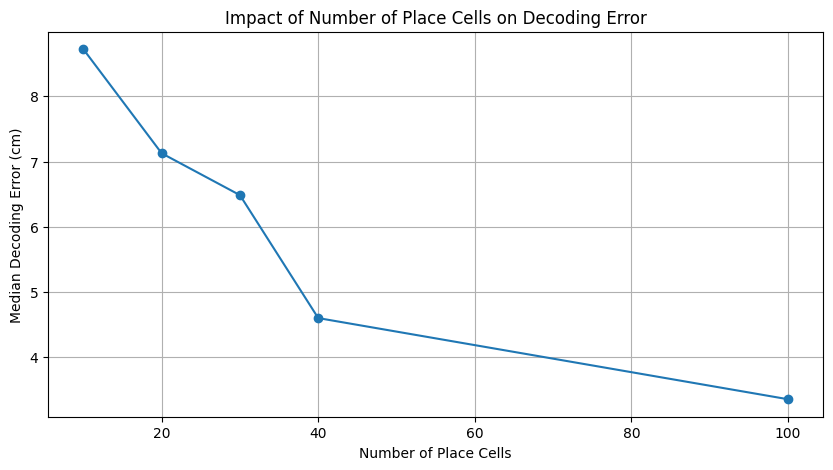

In [10]:
# Define different numbers of place cells to test
cell_numbers = [10, 20, 30, 40, n_cells]
median_errors_cells = []

for n in cell_numbers:
    selected_cells = np.random.choice(n_cells, n, replace=False)
    subsampled_spikes_count = spikes_count[:, selected_cells]
    subsampled_firing_rate_maps = firing_rate_maps[selected_cells, :]
    x_decoded, true_x = decode_position(subsampled_spikes_count, subsampled_firing_rate_maps, space_bins, fps)
    median_error = calculate_median_error(true_x, x_decoded)
    median_errors_cells.append(median_error)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(cell_numbers, median_errors_cells, marker='o')
plt.xlabel('Number of Place Cells')
plt.ylabel('Median Decoding Error (cm)')
plt.title('Impact of Number of Place Cells on Decoding Error')
plt.grid(True)
plt.show()


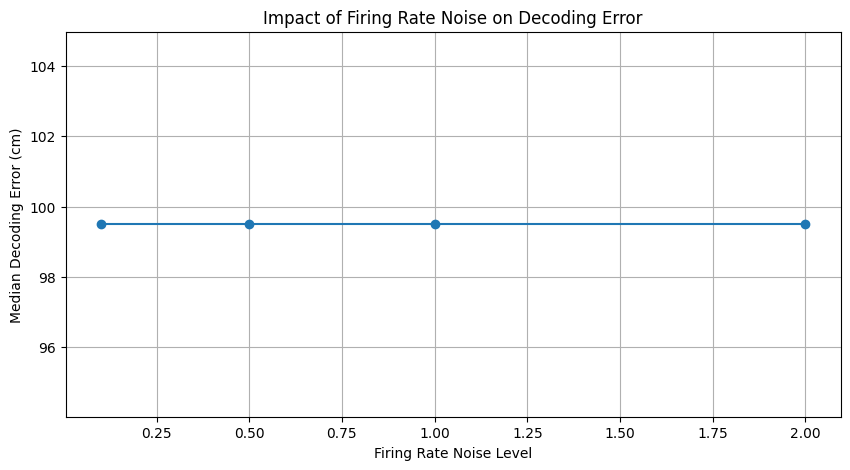

In [11]:
# Define different noise levels
noise_levels = [0.1, 0.5, 1.0, 2.0]
median_errors_noise = []

for noise in noise_levels:
    firing_rate_maps_noisy = firing_rate_maps + np.random.normal(0, noise, firing_rate_maps.shape)
    x_decoded, true_x = decode_position(spikes_count, firing_rate_maps_noisy, space_bins, fps)
    median_error = calculate_median_error(true_x, x_decoded)
    median_errors_noise.append(median_error)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(noise_levels, median_errors_noise, marker='o')
plt.xlabel('Firing Rate Noise Level')
plt.ylabel('Median Decoding Error (cm)')
plt.title('Impact of Firing Rate Noise on Decoding Error')
plt.grid(True)
plt.show()


## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation

In [18]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [19]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [24]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [25]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [26]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)